Import des librairies nécessaires

In [84]:
import math
from enum import Enum

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray


Variables globales

In [85]:
PICTURE_SIZE_SHEET_DETECTION = 1000

Positions des visuels sur le plastron

In [86]:
class Zone(Enum):
    TOP_LEFT = 1
    TOP_RIGHT = 2
    BOTTOM_LEFT = 3
    BOTTOM_RIGHT = 4
    CENTER = 5

Extraction d'un visuel du plastron

In [87]:
def get_crop_coordinates(image: ndarray, target_zone: Zone):
    height, width, _ = image.shape
    x1, x2, y1, y2 = 0, width, 0, height

    if target_zone in [Zone.TOP_RIGHT, Zone.BOTTOM_RIGHT]:
        x1 = int(width / 2)
    if target_zone in [Zone.BOTTOM_LEFT, Zone.BOTTOM_RIGHT]:
        y1 = int(height / 2)
    if target_zone in [Zone.TOP_LEFT, Zone.BOTTOM_LEFT]:
        x2 = int(width / 2)
    if target_zone in [Zone.TOP_LEFT, Zone.TOP_RIGHT]:
        y2 = int(height / 2)
    if target_zone == Zone.CENTER:
        x1, y1 = int(width / 4), int(height / 4)
        x2, y2 = width - x1, height - y1

    return {'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2}


def get_target_picture(sheet_mat: ndarray, target_zone: Zone):
    sheet_mat_clone = sheet_mat.copy()
    coordinates = get_crop_coordinates(sheet_mat_clone, target_zone)
    return sheet_mat_clone[coordinates['x1']:coordinates['x2'], coordinates['y1']:coordinates['y2']]


Test de l'extraction des visuels

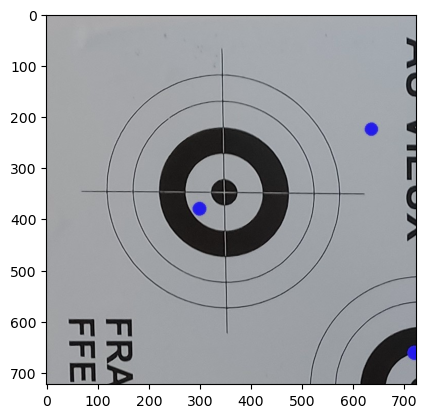

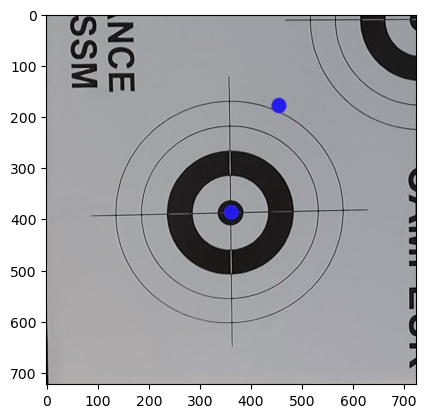

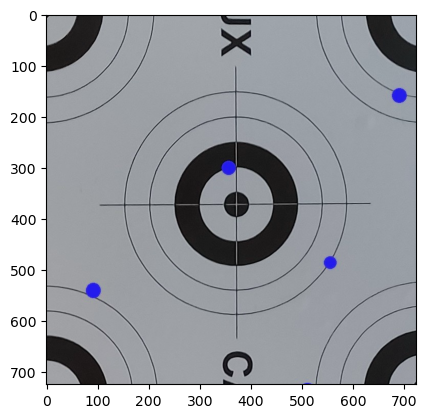

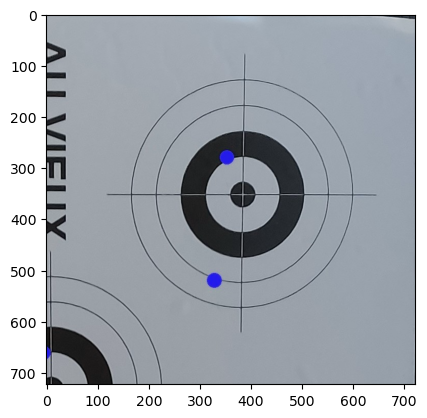

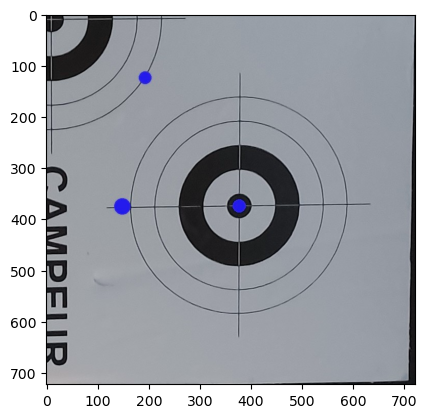

In [88]:
image = cv.imread('images/cropped_sheet.jpg')
zones = [Zone.TOP_LEFT, Zone.TOP_RIGHT, Zone.CENTER, Zone.BOTTOM_LEFT, Zone.BOTTOM_RIGHT]
for zone in zones:
    sheet_mat = get_target_picture(image, zone)
    plt.imshow(sheet_mat)
    plt.show()



Récupération des coordonnées du plastron sur une image

In [89]:
def enhance_image_for_edge_detection(image: ndarray, blur_radius: int = 0):
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    h, saturation, v = cv.split(hsv)
    if blur_radius > 0:
        v = cv.blur(v, (blur_radius, blur_radius))
    return v


def get_edges(image: ndarray, blur_radius: int = 0, canny_threshold_1: int = 100, canny_threshold_2: int = 200):
    image_clone = image.copy()
    if blur_radius > 0:
        image_clone = cv.blur(image_clone, (blur_radius, blur_radius))
    return cv.Canny(image_clone, canny_threshold_1, canny_threshold_2)


def get_biggest_valid_contour(contours):
    biggest_contour = None
    biggest_area = 0
    for contour in contours:
        approx = cv.approxPolyDP(contour, cv.arcLength(contour, True) * 0.01, True)
        if len(approx) != 4 or cv.contourArea(approx) < biggest_area:
            continue
        angles = [math.acos(((p1[0] - p2[0]) * (p3[0] - p2[0]) + (p1[1] - p2[1]) * (p3[1] - p2[1])) /
                            (((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5 *
                             ((p3[0] - p2[0]) ** 2 + (p3[1] - p2[1]) ** 2) ** 0.5)) * 180 / math.pi
                  for i in range(4)
                  for p1, p2, p3 in [(approx[i][0], approx[(i + 1) % 4][0], approx[(i + 2) % 4][0])]]
        if any(angle < 70 or angle > 110 for angle in angles):
            continue
        area = cv.contourArea(approx)
        if area / (PICTURE_SIZE_SHEET_DETECTION * PICTURE_SIZE_SHEET_DETECTION) < 0.1 or area / (
                PICTURE_SIZE_SHEET_DETECTION * PICTURE_SIZE_SHEET_DETECTION) > 0.9:
            continue
        biggest_contour = approx
        biggest_area = area
    return biggest_contour


def coordinates_to_percentage(coordinates, width, height):
    percentage_coordinates = []
    for coordinate in coordinates:
        percentage_coordinates.append((coordinate[0] / width, coordinate[1] / height))
    return percentage_coordinates


def get_sheet_coordinates(sheet_mat: ndarray):
    # Enhance image for edge detection
    enhanced_image = enhance_image_for_edge_detection(
        cv.resize(sheet_mat.copy(), (PICTURE_SIZE_SHEET_DETECTION, PICTURE_SIZE_SHEET_DETECTION)),
        blur_radius=5
    )

    # Get edges and dilate them
    dilated_edges = cv.dilate(
        get_edges(cv.bitwise_not(enhanced_image), blur_radius=5),
        cv.getStructuringElement(cv.MORPH_RECT,
                                 (int(PICTURE_SIZE_SHEET_DETECTION / 90), int(PICTURE_SIZE_SHEET_DETECTION / 90))),
        iterations=2
    )

    # Find contours
    contours, _ = cv.findContours(cv.bitwise_not(dilated_edges), cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
    biggest_contour = get_biggest_valid_contour(contours)
    if biggest_contour is None:
        return None

    # Get coordinates of the biggest contour and convert to percentage
    return coordinates_to_percentage(
        [(biggest_contour[i][0][0], biggest_contour[i][0][1]) for i in range(4)],
        PICTURE_SIZE_SHEET_DETECTION,
        PICTURE_SIZE_SHEET_DETECTION
    )

Test de la récupération des coordonnées du plastron

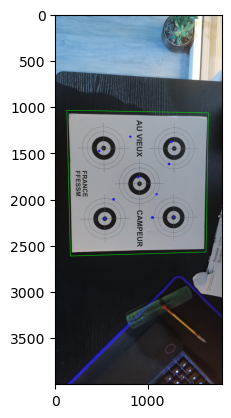

In [90]:
image = cv.imread('images/sheet.jpg')
coordinates = get_sheet_coordinates(image)


def draw_sheet_detection_contour(image, coordinates):
    coordinates_len = len(coordinates)
    for i in range(coordinates_len):
        cv.line(image, coordinates[i], coordinates[(i + 1) % coordinates_len], (0, 255, 0), 3)


def percentage_to_coordinates(percentage_coordinates, width, height):
    coordinates = []
    for percentage_coordinate in percentage_coordinates:
        coordinates.append((int(percentage_coordinate[0] * width), int(percentage_coordinate[1] * height)))
    return coordinates


if coordinates is not None:
    height, width, _ = image.shape
    real_coordinates = percentage_to_coordinates(coordinates, width, height)
    draw_sheet_detection_contour(image, real_coordinates)
    plt.imshow(image)
    plt.show()
else:
    print('No coordinates found')

Extraction de l'image du plastron

In [91]:
def get_sheet_picture(image: ndarray):
    coordinates = get_sheet_coordinates(image)
    if coordinates is None:
        return None
    height, width, _ = image.shape
    real_coordinates = percentage_to_coordinates(coordinates, width, height)


    approx = np.array(real_coordinates, np.float32)
    target_coordinates = np.array([
        [0, 0],
        [PICTURE_SIZE_SHEET_DETECTION, 0],
        [PICTURE_SIZE_SHEET_DETECTION, PICTURE_SIZE_SHEET_DETECTION], [0, PICTURE_SIZE_SHEET_DETECTION]
    ], np.float32)
    transformation_matrix = cv.getPerspectiveTransform(approx, target_coordinates)
    sheet_mat = cv.warpPerspective(image, transformation_matrix,
                                   (PICTURE_SIZE_SHEET_DETECTION, PICTURE_SIZE_SHEET_DETECTION))

    return sheet_mat

Test de l'extraction de l'image du plastron

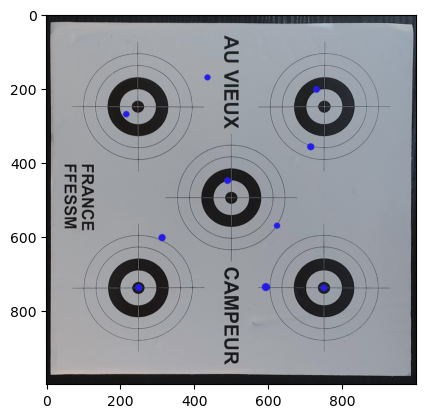

In [92]:
image = cv.imread('images/sheet.jpg')
sheet_mat = get_sheet_picture(image)
plt.imshow(sheet_mat)
plt.show()

Récupération de la couleur des piges

In [96]:
def get_biggest_contour(contours):
    max_area = 0
    biggest_contour = None
    for contour in contours:
        bounding_rect = cv.boundingRect(contour)
        area = bounding_rect[2] * bounding_rect[3]
        if area > max_area:
            max_area = area
            biggest_contour = contour
    return biggest_contour

def get_impacts_color(image:ndarray):
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    h, saturation, v = cv.split(hsv)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(saturation)
    min_val = (max_val - min_val) / 1.05 + min_val
    
    lower_bound = np.array([min_val], dtype=np.uint8)
    upper_bound = np.array([max_val], dtype=np.uint8)
    
    low = np.full((saturation.shape[0], saturation.shape[1]), lower_bound, dtype=np.uint8)
    high = np.full((saturation.shape[0], saturation.shape[1]), upper_bound, dtype=np.uint8)
    
    cv.inRange(saturation, low, high, saturation)
    
    contours, hierarchy = cv.findContours(saturation, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    # Assuming getBiggestContour is a function that returns the biggest contour
    biggest_contour = get_biggest_contour(contours)
    if biggest_contour is None:
        return None
    
    rect = cv.boundingRect(biggest_contour)
    biggest_edge = max(rect[2], rect[3])
    kernel = np.ones((biggest_edge // 4, biggest_edge // 4), np.uint8)
    cv.erode(saturation, saturation, kernel, iterations=1)
    cropped = image[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
    mean_color = cv.mean(cropped)
    return (mean_color[2], mean_color[1], mean_color[0])


Test de la récupération de la couleur des piges

In [97]:
image = cv.imread('images/sheet.jpg')
sheet_mat = get_sheet_picture(image)
color = get_impacts_color(sheet_mat)
print(color)

(0.0, 0.6428571428571428, 2.642857142857143)
